In [1]:
!git clone https://github.com/thanjaivadivelm/Rainfall_forcasting.git

Cloning into 'Rainfall_forcasting'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (5/5), 331.52 KiB | 2.86 MiB/s, done.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import openpyxl
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [7]:
# Load the dataset
data = pd.read_csv('/content/Rainfall_forcasting/dataset/Rainfall-Historical.csv')

In [8]:
# Convert to Time Series
data['Date'] = pd.to_datetime(data['YEAR'], format='%Y')
data.set_index('Date', inplace=True)
bwn_ts = data['ANNUAL']

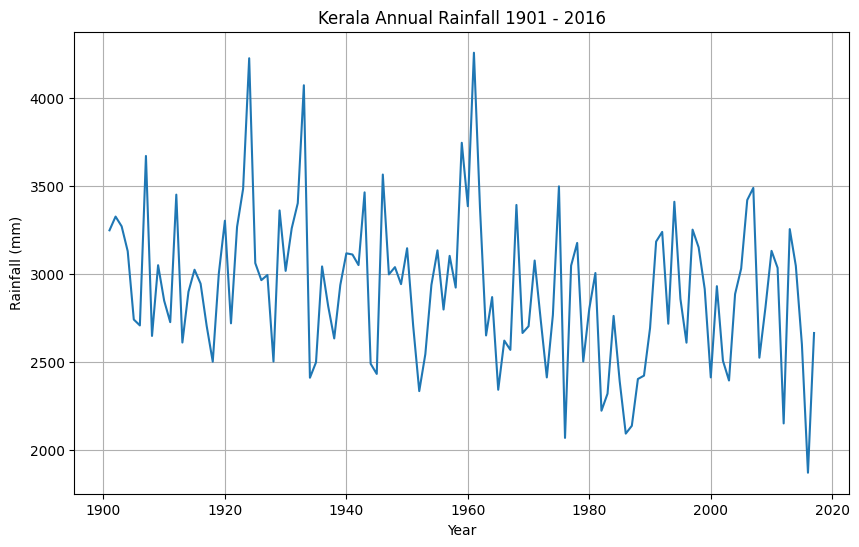

In [9]:
# Plot Time Series Data
plt.figure(figsize=(10, 6))
plt.plot(bwn_ts)
plt.title('Kerala Annual Rainfall 1901 - 2016')
plt.ylabel('Rainfall (mm)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

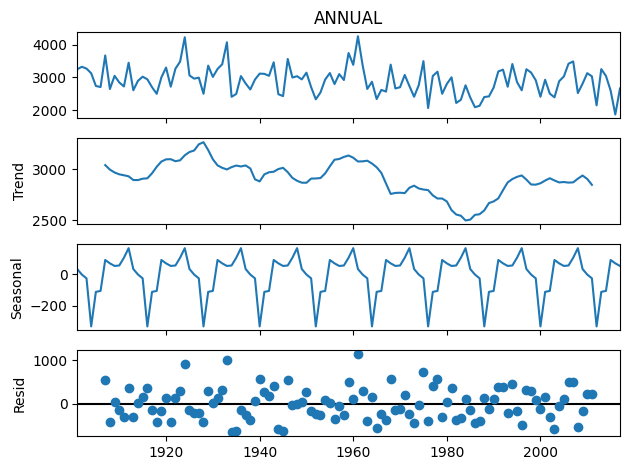

In [11]:
# Decomposition using STL
decomposition = seasonal_decompose(bwn_ts, model='additive', period=12)
decomposition.plot()
plt.show()

In [13]:
# Trend and Seasonal Strength Calculation
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

In [14]:
Ft = max(0, 1 - (residual.var() / (trend + residual).var()))
Fs = max(0, 1 - (residual.var() / (seasonal + residual).var()))

In [15]:
print(f'Trend Strength: {Ft:.1f}')
print(f'Seasonal Strength: {Fs:.1f}')

Trend Strength: 0.2
Seasonal Strength: 0.1


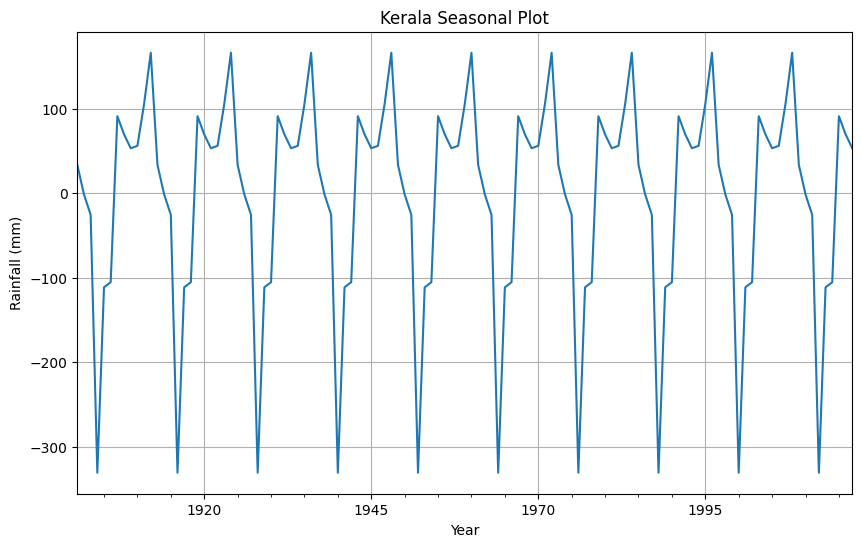

In [16]:
# Seasonal Plot
plt.figure(figsize=(10, 6))
seasonal.plot()
plt.title('Kerala Seasonal Plot')
plt.ylabel('Rainfall (mm)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

In [17]:
# Create Train and Test Sets

train_end = '2018'
test_start = '2019'

bwn_train = bwn_ts[:train_end]
bwn_test = bwn_ts[test_start:]

In [18]:
# KPSS Test
kpss_test = kpss(bwn_train)
print('KPSS Test Statistic:', kpss_test[0])
print('KPSS p-value:', kpss_test[1])

KPSS Test Statistic: 0.5968309294742977
KPSS p-value: 0.022924460956882022


In [20]:
# ADF Test
adf_test = adfuller(bwn_train)
print('ADF Test Statistic:', adf_test[0])
print('ADF p-value:', adf_test[1])

ADF Test Statistic: -1.966055101492665
ADF p-value: 0.3016521447111502


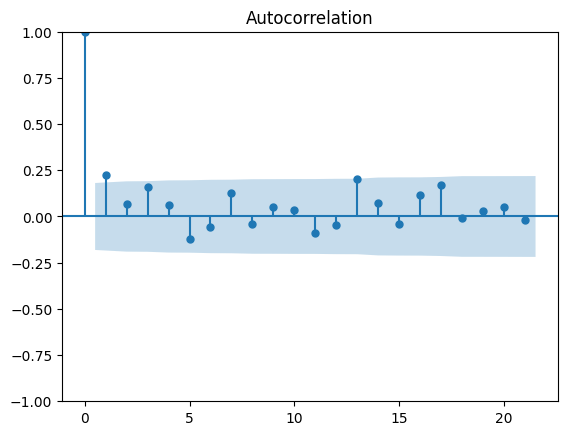

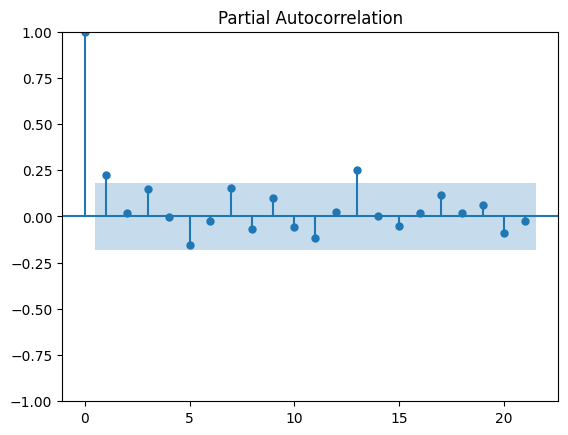

In [21]:
# ACF/PACF Plot
plot_acf(bwn_train)
plot_pacf(bwn_train)
plt.show()

In [22]:
# ARIMA Model Selection
model1 = ARIMA(bwn_train, order=(1, 0, 2), seasonal_order=(1, 0, 2, 12)).fit()
model2 = ARIMA(bwn_train, order=(1, 1, 2), seasonal_order=(1, 1, 2, 12)).fit()
model3 = ARIMA(bwn_train, order=(0, 0, 2), seasonal_order=(0, 0, 2, 12)).fit()
model4 = ARIMA(bwn_train, order=(2, 0, 1), seasonal_order=(2, 0, 1, 12)).fit()
model5 = ARIMA(bwn_train, order=(1, 2, 1), seasonal_order=(1, 2, 1, 12)).fit()

In [23]:
aic_values = {
    'Model-1': model1.aic,
    'Model-2': model2.aic,
    'Model-3': model3.aic,
    'Model-4': model4.aic,
    'Model-5': model5.aic
}

In [24]:
print(pd.DataFrame(aic_values, index=["AIC Value"]))

               Model-1      Model-2      Model-3      Model-4      Model-5
AIC Value  1757.308035  1588.458813  1755.292419  1756.907843  1478.095757


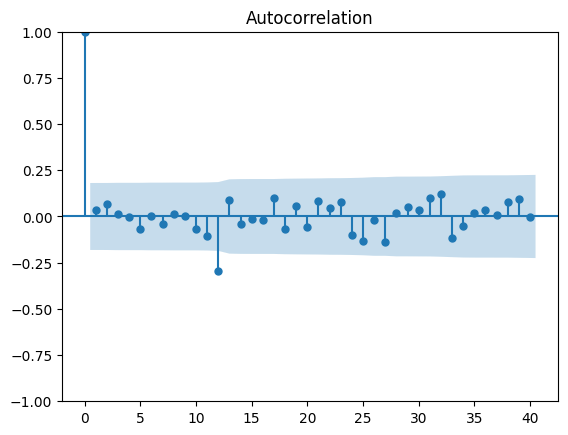

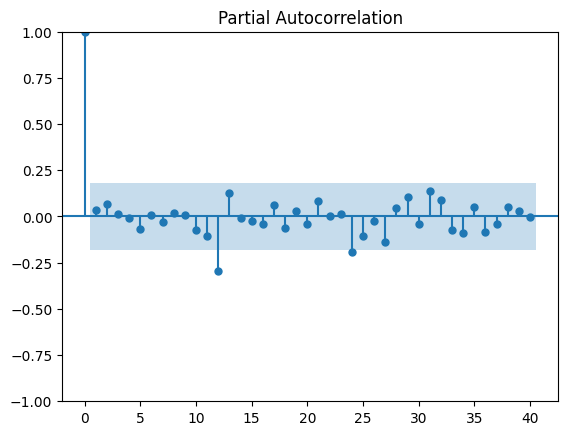

In [25]:
# Check residuals of the best model
sm.graphics.tsa.plot_acf(model2.resid, lags=40)
sm.graphics.tsa.plot_pacf(model2.resid, lags=40)
plt.show()

In [26]:
# ARIMA Model Accuracy
start = len(bwn_train)
end = len(bwn_train) + len(bwn_test)
forecast = model2.get_forecast(start,end)
forecast_values = forecast.predicted_mean
bwn_test_array = np.array(bwn_test)
forecast_array = np.array(forecast_values)

In [27]:
# Create Final Model and Forecast
final_model = ARIMA(bwn_ts, order=(1, 1, 2), seasonal_order=(1, 1, 2, 12)).fit()
forecast_data = final_model.get_forecast(steps=240).predicted_mean

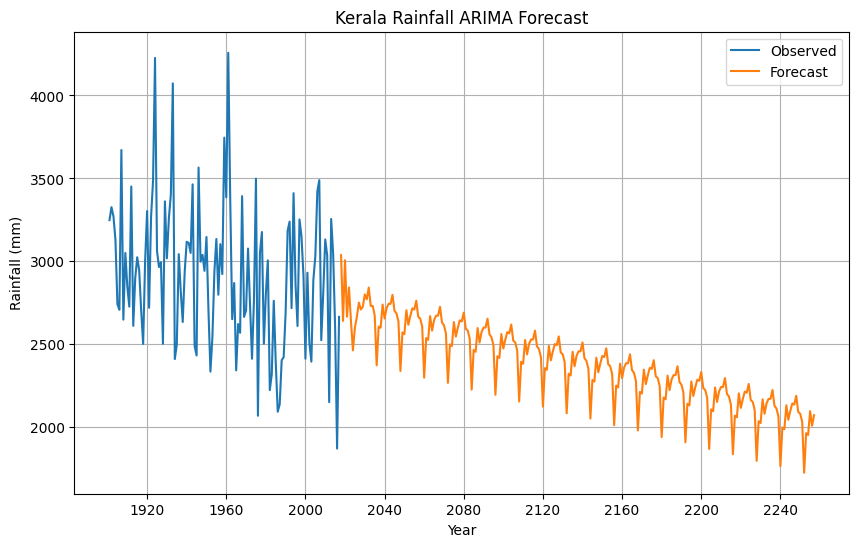

In [28]:
# Plot Forecast
plt.figure(figsize=(10, 6))
plt.plot(bwn_ts, label='Observed')
plt.plot(forecast_data, label='Forecast')
plt.title('Kerala Rainfall ARIMA Forecast')
plt.ylabel('Rainfall (mm)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Convert forecast data to DataFrame
forecast_df = pd.DataFrame(forecast_data, columns=['Forecast'])

In [30]:
# Save forecast data to Excel
forecast_df.to_excel('forecast_data.xlsx', index=False)